## Imports

In [42]:
import os, glob
import ast
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch as th
import torch.nn as nn
import dgl

from radon.complexity import cc_visit
from radon.metrics import mi_compute
from radon.metrics import h_visit_ast
from radon.visitors import ComplexityVisitor
from radon.visitors import HalsteadVisitor
from radon.raw import analyze
from radon.metrics import mi_visit


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## Loading Dataset

In [20]:
with open("ideas.md") as f:
    ideas = f.readlines()
# get lines starting with - or =- and remove the - or =-
ideas = [i.strip()[1:] for i in ideas if i.startswith("-") or i.startswith("=-")]
len(ideas)

131

## Helper Functions

In [55]:
def generate_ast_graph(node):
    """
    Recursively generate a networkx tree graph of an AST using a custom NodeVisitor class,
    retaining the order of the visit.
    """
    class Visitor(ast.NodeVisitor):
        def __init__(self):
            self.graph = nx.DiGraph()
            self.counter = 0
            self.parent = None
        
        def generic_visit(self, node):
            node_id = self.counter
            self.counter += 1
            self.graph.add_node(node_id, label=type(node).__name__)
            if self.parent is not None:
                self.graph.add_edge(self.parent, node_id)
            self.parent = node_id
            ast.NodeVisitor.generic_visit(self, node)
            self.parent = node_id
    
    visitor = Visitor()
    visitor.visit(node)
    return visitor.graph

def plot_graph(graph, label=0, ax=None):
    # Draw graph
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Create the title for the ax, not a new figure
    if ax is not None:
        ax.set_title(label, fontsize=12)
    else:
        plt.title(label, fontsize=12)
    nx.draw(
        graph,
        labels=nx.get_node_attributes(graph, "label"),
        font_weight="bold",
        node_size=200,
        node_color="skyblue",
        pos=pos,
        font_size=5,
        width=3,
        edge_color="black",
        arrowsize=5,
        arrowstyle="-|>",
        arrows=True,
        alpha=0.5,
        linewidths=1.5,
        style="dashed",
        ax=ax,  # draw on the passed in ax
    )

def get_py_files(folder_to_crawl):
    "folder_to_crawl: '3.5turbo' or 'humanCode'"
    CWD = os.getcwd()
    CODE_DIR = os.path.join(CWD, folder_to_crawl)
    files = glob.glob(os.path.join(CODE_DIR, '**/*.py'), recursive=True)
    Code_dirs = [f.split(folder_to_crawl)[1].split("/") for f in files]
    Code_df = pd.DataFrame(Code_dirs, columns=['Preamble', 'Category', 'Subcategory', 'Filename'], index = None)
    return Code_df

def get_ast_graphs(df, folder_to_crawl):
    ast_graph_df = df.copy()
    CWD = os.getcwd()
    ast_graph_df["AST"] = None
    ast_graph_df["Graph"] = None
    for i, row in enumerate(ast_graph_df.iterrows()):
        row = os.path.join(row[1]['Category'], row[1]['Subcategory'], row[1]['Filename'])
        PATH = os.path.join(CWD, folder_to_crawl, row)
        with open(PATH) as f:
            code = f.readlines()
        code_ast = ast.parse("".join(code))
        ast_graph_df["AST"].loc[i] = code_ast
        ast_graph_df["Graph"].loc[i] = generate_ast_graph(code_ast)
    return ast_graph_df

def get_metrics(df, folder_to_crawl):
    metrics_graph_df = df.copy()
    CWD = os.getcwd()
    metrics_graph_df['Cyclomatic_Complexity'] = None
    metrics_graph_df['Halstead_Difficulty'] = None
    metrics_graph_df['Halstead_Effort'] = None
    metrics_graph_df['Halstead_Volume'] = None
    metrics_graph_df['Halstead_Time'] = None
    metrics_graph_df['Halstead_Bugs'] = None
    metrics_graph_df['SLoC'] = None
    metrics_graph_df["Logical_SLoC"] = None
    metrics_graph_df['Number_of_Functions'] = None
    metrics_graph_df['Number_of_Classes'] = None
    metrics_graph_df['Number_of_Statements'] = None
    metrics_graph_df['Number_of_Comments'] = None
    metrics_graph_df['Diff_SLoC_LLoC'] = None
    metrics_graph_df['Maintainability_Index'] = None
    for i, row in enumerate(metrics_graph_df.iterrows()):
        row = os.path.join(row[1]['Category'], row[1]['Subcategory'], row[1]['Filename'])
        PATH = os.path.join(CWD, folder_to_crawl, row)
        with open(PATH) as f:
            code = f.readlines()
        ast_code = ast.parse("".join(code))
        complexity = ComplexityVisitor.from_code(ast_code)
        metrics_graph_df['Cyclomatic_Complexity'].iloc[i] = complexity.total_complexity
        #metrics_graph_df['SLoC'].loc[i] = analyze(code).sloc #complexity[0].nloc#
        #hal = HalsteadVisitor.from_code("".join(code))
        hal_visit = h_visit_ast(ast.parse("".join(code)))
        hal = hal_visit[0]
        
        metrics_graph_df['Halstead_Difficulty'].iloc[i] = hal.difficulty
        metrics_graph_df['Halstead_Effort'].iloc[i] = hal.effort
        metrics_graph_df['Halstead_Volume'].iloc[i] = hal.volume
        metrics_graph_df['Halstead_Time'].iloc[i] = hal.time
        metrics_graph_df['Halstead_Bugs'].iloc[i] = hal.bugs
        
        metrics_graph_df['SLoC'].iloc[i] = analyze("".join(code)).sloc
        metrics_graph_df["Logical_SLoC"].iloc[i] = analyze("".join(code)).lloc
        metrics_graph_df['Diff_SLoC_LLoC'].iloc[i] = abs(analyze("".join(code)).sloc - analyze("".join(code)).lloc)

        metrics_graph_df['Number_of_Functions'].iloc[i] = len(hal_visit[1])#analyze(code).functions
        metrics_graph_df['Number_of_Classes'].iloc[i] = len(complexity.classes)#analyze(code).classes
        metrics_graph_df['Number_of_Statements'].iloc[i] = analyze("".join(code)).loc
        metrics_graph_df['Number_of_Comments'].iloc[i] = analyze("".join(code)).comments
        
        metrics_graph_df['Maintainability_Index'].iloc[i] = mi_visit("".join(code), True)
        
        # try:
        #     maintain_index = mi_compute(hal.volume, complexity[0].complexity, analyze("".join(code)).sloc, analyze("".join(code)).comments)
        #     metrics_graph_df['Maintainability_Index'].loc[i] = maintain_index
        # except:
        #     print(str(PATH.split("/")[6:]))
        #     metrics_graph_df['Maintainability Index'].loc[i] = 0
    return metrics_graph_df
  # label for a list of nodes

def get_label(graph, nodes):
    return [graph.nodes[x]["label"] for x in nodes]

def get_traversal_labels(graph, traversal= nx.dfs_postorder_nodes):
    traversed_labels = get_label(graph, list(traversal(graph, 0)))
    return traversed_labels

def get_traversed_seqs(total_unique_nodes, padded_graphs):
    traversed_seq_indexes = []
    for i, graph in tqdm(enumerate(padded_graphs), total=len(padded_graphs)):
        traversed_seq = list(get_traversal_labels(graph, nx.dfs_postorder_nodes))
        if len(traversed_seq) < 2:
            print(f"This one has less than 2 nodes")
            continue
        traversed_seq_indexes.append([total_unique_nodes.index(word) for word in traversed_seq])
    return traversed_seq_indexes

def pad_trarsed_trees(traversed_seq_indexes, max_len=1000):
    pad_traversed_seq_indexes_array = np.zeros((len(traversed_seq_indexes), max_len))
    for i, seq in enumerate(traversed_seq_indexes):
        if len(seq) >= max_len:
            seq = seq[:max_len]
        else:
            seq = seq + [0] * (max_len - len(seq))
        pad_traversed_seq_indexes_array[i] = np.array(seq)
    return pad_traversed_seq_indexes_array

def get_all_nodes(Code_df):
    nodes_corpus = []
    for graph in Code_df['Graph'].values:
        nodes_corpus.extend(get_label(graph,graph.nodes()))

    return nodes_corpus

## Get the py files

In [52]:
ChatGPT_df = get_py_files('3.5turbo')
humanCode_df = get_py_files('humanCode')
# ChatGPT_df = get_ast_graphs(ChatGPT_df, "3.5turbo")
# humanCode_df = get_ast_graphs(humanCode_df, "humanCode")
ChatGPT_df = get_metrics(ChatGPT_df, "3.5turbo")
humanCode_df = get_metrics(humanCode_df, "humanCode")

In [54]:
humanCode_df['Maintainability_Index']

0      99.903482
1      68.723019
2          100.0
3      89.240546
4          100.0
         ...    
126        100.0
127        100.0
128    82.593916
129    44.036983
130    60.531623
Name: Maintainability_Index, Length: 131, dtype: object

In [24]:
# Finds the distance between the filenames of the two datasets using Levenshtein distance to see if there are any mismatches
import Levenshtein
filenames_df = pd.DataFrame(pd.concat([ChatGPT_df["Filename"].rename("Filename_ChatGPT"), humanCode_df["Filename"].rename("Filename_humanCode")], axis=1))
filenames_df["Levenshtein_Distance"] = None
for i, row in enumerate(filenames_df.iterrows()):
    filenames_df["Levenshtein_Distance"].loc[i] = Levenshtein.distance(row[1]["Filename_ChatGPT"], row[1]["Filename_humanCode"])
# If there are mismatches this will show them
filenames_df[filenames_df["Levenshtein_Distance"] > 0]

ModuleNotFoundError: No module named 'Levenshtein'

In [25]:
# Check if there are any files remaining in the humanCode dataset that are in the ChatGPT dataset
(ChatGPT_df.groupby(['Category', 'Subcategory']).count()['Filename'] - humanCode_df.groupby(['Category', 'Subcategory']).count()['Filename'])

Category                    Subcategory                             
algorithms-data-structures  code-optimization-time-complexity           0
                            general                                     0
                            implementation                              0
                            recursion                                   0
data-analysis               data-storage                                0
                            data-visualizations                         0
                            iris-flower-dataset-problems                0
                            ml-predictive-models                        0
                            sentiment-dataset-problems                  0
                            statistics                                  0
mathematics                 algebra                                     0
                            calculus-calculators                        0
                            discrete-graphs

## Train and Test Split

In [27]:
# Split the rows grouped by Category into train and test
def get_test_train_indexes(df):
    train_indexes = []
    test_indexes = []
    train_indexes = df.groupby(['Category']).apply(lambda x: x.sample(frac=0.8)).index
    test_indexes = df.drop([x[1] for x in train_indexes]).index
    train_indexes = [x[1] for x in train_indexes]
    test_indexes = [x for x in test_indexes]
    return train_indexes, test_indexes

ChatGPT_train_indexes, ChatGPT_test_indexes = get_test_train_indexes(ChatGPT_df)
humanCode_train_indexes, humanCode_test_indexes = get_test_train_indexes(humanCode_df)

train_ChatGPT_ast_graph_df = ChatGPT_df.loc[ChatGPT_train_indexes]
test_ChatGPT_ast_graph_df = ChatGPT_df.loc[ChatGPT_test_indexes]

train_humanCode_ast_graph_df = humanCode_df.loc[humanCode_train_indexes]
test_humanCode_ast_graph_df = humanCode_df.loc[humanCode_test_indexes]

# Check if size make sense
print(f"Test {len(test_ChatGPT_ast_graph_df)} + Train: {len(train_ChatGPT_ast_graph_df)} == Total: {len(ChatGPT_df)} => {len(test_humanCode_ast_graph_df) + len(train_humanCode_ast_graph_df) == len(humanCode_df)}")
print(f"Test: {len(test_humanCode_ast_graph_df)} + Train: {len(train_humanCode_ast_graph_df)} == Total: {len(humanCode_df)} => {len(test_humanCode_ast_graph_df) + len(train_humanCode_ast_graph_df) == len(humanCode_df)}")

Test 26 + Train: 105 == Total: 131 => True
Test: 26 + Train: 105 == Total: 131 => True


In [28]:
select_columns = list(train_ChatGPT_ast_graph_df.columns)[4:]
#select_columns = ["Graph"]

train_GPT_data = train_ChatGPT_ast_graph_df[select_columns]
test_GPT_data = test_ChatGPT_ast_graph_df[select_columns]

train_GPT_keys = train_ChatGPT_ast_graph_df["Filename"].values
test_GPT_keys = test_ChatGPT_ast_graph_df["Filename"].values

train_human_data = train_humanCode_ast_graph_df[select_columns]
test_human_data = test_humanCode_ast_graph_df[select_columns]

train_human_keys = train_humanCode_ast_graph_df["Filename"].values
test_human_keys = test_humanCode_ast_graph_df["Filename"].values

In [30]:
train_data = pd.concat([train_GPT_data, train_human_data], ignore_index=True)
test_data = pd.concat([test_GPT_data, test_human_data], ignore_index=True)
train_keys = train_GPT_keys.tolist() + train_human_keys.tolist()
test_keys = test_GPT_keys.tolist() + test_human_keys.tolist()


train_labels_GTP = np.zeros(len(train_GPT_keys))
train_labels_human = np.ones(len(train_human_keys))
train_labels = train_labels_GTP.tolist() + train_labels_human.tolist()

test_labels_GTP = np.zeros(len(test_GPT_keys))
test_labels_human = np.ones(len(test_human_keys))
test_labels = test_labels_GTP.tolist() + test_labels_human.tolist()


In [31]:
# Check if there are dublicates in the keys
print("If duplicates in keys (filenames) these pairs should not match")
print(((len(train_GPT_keys), len(np.unique(train_GPT_keys)))), ((len(train_human_keys), len(np.unique(train_human_keys)))))
print((len(train_human_keys), len(np.unique(train_human_keys))), (len(train_GPT_keys), len(np.unique(train_GPT_keys))))

# print("Trainset and Testset lens")
print(len(train_data), len(train_labels), len(train_keys), len(test_data), len(test_labels), len(test_keys))


If duplicates in keys (filenames) these pairs should not match
(105, 105) (105, 105)
(105, 105) (105, 105)
210 210 210 52 52 52


## Metrics Dataset

In [33]:
# Code Here
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score



rf_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 100, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 3, random_state= 80)
xgb_clf = XGBClassifier(colsample_bytree=0.3, learning_rate=0.042260584879943656, max_depth=2, min_child_weight=1, n_estimators=117, subsample=0.7114361356127834)

for clf in [rf_clf, xgb_clf]:
    prev_weigted_f1 = 0
    prev_random_state = 0
    prev_classification_report = None
    prev_clf = None
    if clf.__class__.__name__ == "RandomForestClassifier":
        itter = 1000
    elif clf.__class__.__name__ == "XGBClassifier":
        itter = 1
    for i in tqdm(range(itter)):
        random_state = 80
        clf.random_state = random_state
        clf.fit(np.array(train_data.values), train_labels)
        pred = clf.predict(np.array(test_data.values))
        weigted_f1 = f1_score(test_labels, pred, average='macro')
        if prev_weigted_f1 < weigted_f1:
            prev_clf = clf
            prev_weigted_f1 = weigted_f1
            prev_random_state = random_state
            prev_classification_report = classification_report(test_labels, pred)

    print(f"Best Random State: {prev_random_state}")
    print(prev_clf.__class__.__name__)
    print(prev_classification_report)

100%|██████████| 1000/1000 [00:04<00:00, 227.67it/s]


Best Random State: 80
RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63        26
         1.0       0.63      0.65      0.64        26

    accuracy                           0.63        52
   macro avg       0.63      0.63      0.63        52
weighted avg       0.63      0.63      0.63        52



100%|██████████| 1/1 [00:00<00:00, 15.11it/s]

Best Random State: 80
XGBClassifier
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.71        26
         1.0       0.70      0.73      0.72        26

    accuracy                           0.71        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.71      0.71      0.71        52



In [34]:
clf = RandomForestClassifier(criterion= 'entropy', max_depth= 100, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 3, random_state= 80)
clf.fit(np.array(train_data.values), train_labels)
pred = clf.predict(np.array(test_data.values))
weigted_f1 = f1_score(test_labels, pred, average='macro')
print(classification_report(test_labels, pred))

              precision    recall  f1-score   support

         0.0       0.64      0.62      0.63        26
         1.0       0.63      0.65      0.64        26

    accuracy                           0.63        52
   macro avg       0.63      0.63      0.63        52
weighted avg       0.63      0.63      0.63        52



In [35]:
print(f"Best Random Forest Classifier: {prev_random_state}")
print(prev_classification_report)

Best Random Forest Classifier: 80
              precision    recall  f1-score   support

         0.0       0.72      0.69      0.71        26
         1.0       0.70      0.73      0.72        26

    accuracy                           0.71        52
   macro avg       0.71      0.71      0.71        52
weighted avg       0.71      0.71      0.71        52



## Tree LSTM

In [ ]:
full_data = pd.concat([train_data, test_data], ignore_index=True)
nodes_corpus = get_all_nodes(full_data)
total_unique_nodes = list(set(nodes_corpus))
total_unique_nodes.insert(0, "PAD")

In [12]:
def get_dgl_graph(graphs, graph_classes, graphs_vocab):
    """ Converts the sequence of graphs to sequence of dgl graphs, populates node masks, x, y
        Inputs: 
            graphs: list of networkx graphs
            grade_class: class of the graph
            graphs_vocab: vocabulary of the graphs
        Returns: 
            list of dgl graphs
    """
    dgl_graphs = []
    for i, graph in enumerate(graphs):
        grade_class = graph_classes[i]
        dgl_graph = dgl.from_networkx(graph)

        mask = th.ones(len(dgl_graph.nodes()))
        dgl_graph.ndata["mask"] = mask.long()
        dgl_graph.ndata["y"] = th.tensor([grade_class]* len(graph.nodes())).reshape(-1)
        x = th.tensor(
            [graphs_vocab.index(node) for node in get_label(graph, graph.nodes())]
        )
        dgl_graph.ndata["x"] = x.long()
        dgl_graphs.append(dgl_graph)
    return dgl_graphs


In [13]:
trainset_dgl_graphs = get_dgl_graph(list(train_data.values), train_labels, list(total_unique_nodes))
testset_dgl_graphs = get_dgl_graph(list(test_data.values), test_labels, list(total_unique_nodes))
len(trainset_dgl_graphs), len(testset_dgl_graphs)
train_end_indexes = []
for i, graphs in enumerate(trainset_dgl_graphs):
    train_end_indexes.append([len(graphs.nodes())])
train_end_indexes = np.array(train_end_indexes).reshape(-1)

In [14]:
from collections import namedtuple
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn.init as init
from IPython.display import clear_output
import torch.nn.utils as utils
import torch.nn.functional as F
SSTBatch = namedtuple("SSTBatch", ["graph", "mask", "wordid", "label"])
def batcher(dev):
    def batcher_dev(batch):
        batch_trees = dgl.batch(batch)
        return SSTBatch(
            graph=batch_trees,
            mask=batch_trees.ndata["mask"].to(dev),
            wordid=batch_trees.ndata["x"].to(dev),
            label=batch_trees.ndata["y"].to(dev),
        )
    return batcher_dev

In [92]:
# Code Here

# TreeLSTM-Padded LSTM Model
def get_device(h):
    if h.is_cuda:
        return f"{h.device.type}:{h.device.index}"
    else:
        return th.device("cpu")
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        th.nn.init.xavier_uniform(m.weight)
        th.nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_uniform(param)
    elif isinstance(m, nn.LSTMCell):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.xavier_uniform(param)
        # inidtiallize to something else
        #m.weight.data.uniform_(-0.1, 0.1)
        #m.bias.data.fill_(0)

class TreeLSTMCell(nn.Module):
    def __init__(self, x_size, h_size):
        super(TreeLSTMCell, self).__init__()
        self.W_iou = nn.Linear(x_size, 3 * h_size, bias=True)
        self.U_iou = nn.Linear(h_size, 3 * h_size, bias=True)
        self.b_iou = nn.Parameter(th.zeros(1, 3 * h_size))
        self.U_f = nn.Linear(h_size, h_size)

    def message_func(self, edges):
        return {"h": edges.src["h"],"c": edges.src["c"],}

    def reduce_func(self, nodes):
        h_sum = th.sum(nodes.mailbox["h"], 1)
        # equation (2)
        f = th.sigmoid(self.U_f(nodes.mailbox["h"]))
        f = f.view(-1, 1, nodes.mailbox["h"].size(2))
        f = f.repeat(1, nodes.mailbox["h"].size(1), 1)
        # second term of equation (5)
        c = th.sum(f * nodes.mailbox["c"], 1)

        iou = self.U_iou(h_sum) + self.b_iou

        return {"iou": iou, "c": c}

    def apply_node_func(self, nodes):
        # equation (1), (3), (4)
        iou = nodes.data["iou"] + self.b_iou
        i, o, u = th.chunk(iou, 3, 1)
        i, o, u = th.sigmoid(i), th.sigmoid(o), th.tanh(u)
        # equation (5)
        c = i * u + nodes.data["c"]
        # equation (6)
        h = o * th.tanh(c)
        return {"h": h, "c": c}

class TreeLSTM(nn.Module):
    def __init__(
        self, num_vocabs, x_size, h_size, num_classes, dropout, pretrained_emb=None
    ):
        super(TreeLSTM, self).__init__()
        self.x_size = x_size
        self.seq_out = h_size
        self.lstm_out = h_size
        self.bidirectional = True

        self.embedding = nn.Embedding(num_vocabs, x_size)
        if pretrained_emb is not None:
            self.embedding.weight.data.copy_(pretrained_emb)
            self.embedding.weight.requires_grad = False

        self.dropout = nn.Dropout(dropout)
        self.cell = TreeLSTMCell(x_size, h_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.fcn = nn.Linear(h_size, h_size)
        self.fcn = nn.Sequential(
            nn.Linear(h_size, int(h_size/4)),
            nn.Softmax(dim=1),
            nn.Linear(int(h_size/4), self.seq_out),
            nn.Softmax(dim=1) 
        )
        self.output = nn.Linear(self.seq_out, num_classes)
    
    def forward(self, batch, h, c, end_indexes):
        device = get_device(h)
        g = batch.graph.to(device)
        g = dgl.graph(g.edges())
        embeds = self.embedding(batch.wordid * batch.mask).float()

        g.ndata["iou"] = self.cell.W_iou(
            self.dropout(embeds)
        ) * batch.mask.float().unsqueeze(-1)
        g.ndata["h"] = h
        g.ndata["c"] = c

        dgl.prop_nodes_topo(
            g,
            message_func=self.cell.message_func,
            reduce_func=self.cell.reduce_func,
            apply_node_func=self.cell.apply_node_func,
        )
        
        # Add more sequential layers and dropout after tree lstm output
        h = g.ndata.pop("h")
        h_fcn = self.fcn(h)

        start_index = 0
        end_index = 0
        end_indexes = end_indexes.reshape(-1)
        # print("end_indexes (before cumsum): ",end_indexes)
        end_indexes = np.cumsum(end_indexes)
        averaged_tensor = th.empty(0, h_fcn.shape[1]).to(device)
        for j in range(-1, len(end_indexes)-1):
            if j == -1:
                start_index = 0
                end_index = end_indexes[0]
            else:
                start_index = end_indexes[j]
                end_index = end_indexes[j+1]
            #print(f"h_fcn[{start_index}:{end_index}].size(): ", h_fcn[start_index:end_index].size())
            #root_h_fcn = th.mean(h_fcn[start_index:end_index], dim=0).unsqueeze(0)
            # pick the last one from root_h_fcn
            #root_h_fcn_index = end_index-1#th.tensor([h_fcn[start_index:end_index].size()[0]-1]).to(device)
            #print(f"root_h_fcn_index: {root_h_fcn_index}")
            #print(f"root_h_fcn_index.size(): {root_h_fcn_index.size()}")
            root_h_fcn = th.mean(h_fcn[start_index:end_index], axis=0).view(1, -1)
            #print(f"root_h_fcn.size(): {root_h_fcn.size()}")
            #print(f"averaged_tensor.size(): {averaged_tensor.size()}")
            averaged_tensor = th.cat((averaged_tensor, root_h_fcn), 0)
        #print("end_indexes: ",end_indexes)
        # print("averaged_tensor.size(): ", averaged_tensor.size())
        logits = self.softmax(self.output(averaged_tensor)) # fix from ChatGPT - for multi-class classification, it is common to use a softmax activation function instead of ReLu
        return logits


In [99]:
# Import clear_output
# export LD_LIBRARY_PATH=/home/hamid/Desktop/cuda/lib64:$LD_LIBRARY_PATH
PATH = "./model_checkpoints"
device = th.device("cuda:1" if th.cuda.is_available() else "cpu")
# Setting hyperparameters
x_size, h_size, dropout, lr, weight_decay, epochs, num_vocabs, num_classes = 32, 32, 0.5, 0.0001, 1e-4, 100, len(total_unique_nodes), 2

# Create the model
model = TreeLSTM(num_vocabs, x_size, h_size, num_classes, dropout)
model.apply(init_weights)
model_files = glob.glob(f"{PATH}/model*")
prev_epoch = 0#int(re.findall(r'\d+', model_files[0])[0])
prev_lr = 0.0001#float("0." + re.findall(r"\d+", model_files[0])[2])
print(f"Loading model trained for {prev_epoch} with LR {prev_lr} named {model_files}")
#model.load_state_dict(th.load(model_files[0]))
model = model.to(device)

# create the optimizer
optimizer = th.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=2, gamma=0.8)

batches = 1
tiny_sst = trainset_dgl_graphs
train_loader = DataLoader(
    dataset=tiny_sst,
    batch_size=batches, # 122 or 464  or 926 or 28243
    collate_fn=batcher(device),
    shuffle=False,
    num_workers=0,
)

# training loop
prev_acc = 0
for epoch in range(epochs + 1):
    total_acc = 0
    total_loss = 0
    graph_index = 0
    all_pred = th.empty(0)
    all_label = th.empty(0)

    # Clear cell output
    #clear_output(wait=True)
    for step, batch in enumerate(tqdm(train_loader, total=len(train_loader), desc="Training: Epoch {}".format(epoch))):
        g = batch.graph.to(device)
        n = g.number_of_nodes()
        h = th.zeros((n, h_size), requires_grad=True).to(device)
        c = th.zeros((n, h_size), requires_grad=True).to(device)
        h = init.xavier_uniform_(h)
        c = init.xavier_uniform_(c)

        if len(train_end_indexes) >= (step+1)*batches:
            logits = model(batch, h, c, train_end_indexes[step*batches:(step+1)*batches])
        else:
            continue

        labels_batch = th.tensor([train_labels[step*batches:(step+1)*batches]])
        labels_batch = labels_batch.squeeze(0)
        logp = F.softmax(logits, 1)
        all_label = th.cat((all_label, labels_batch)).float()
      
        #loss = F.nll_loss(logp.cpu().squeeze(1), labels_batch.cpu().long())
        loss = F.cross_entropy(logits.cpu().squeeze(1), labels_batch.cpu().long())
        optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        pred = th.argmax(logp.squeeze(1), 1)
        all_pred = np.append(all_pred, pred.cpu().numpy())

    # Compute confusion matrix for the model
    _report = classification_report(all_label, all_pred, zero_division=0)
    total_acc = accuracy_score(all_label, all_pred)

    print(
        "Epoch {:05d} | LR {:05f} | Step {:05d} | Acc {:.4f} |".format(
            epoch + prev_epoch,
            optimizer.param_groups[0]["lr"],
            step,
            total_acc,
        )
    )
    print(_report)
    if prev_acc <= total_acc:
            prev_acc = total_acc
            # Export the model
            model_name = f"model_{epoch+prev_epoch}_{optimizer.param_groups[0]['lr']}_{total_acc:.4f}.pth"
            model_path = os.path.join(f"{PATH}", model_name)
            th.save(model.state_dict(), model_path)

            # Remove previous model checkpoints
            for prev_model_path in glob.glob(f"{PATH}/*.pth"):
                if prev_model_path != model_path:
                    os.remove(prev_model_path)
    else:
        scheduler.step()


/tmp/ipykernel_3365642/1141161594.py:12: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  th.nn.init.xavier_uniform(m.weight)


Loading model trained for 0 with LR 0.0001 named ['./model_checkpoints/model_13_0.0001_0.5048.pth']


Training: Epoch 0: 100%|██████████| 209/209 [00:15<00:00, 13.63it/s]


Epoch 00000 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 1:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 1: 100%|██████████| 209/209 [00:14<00:00, 14.17it/s]


Epoch 00001 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 2:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 2: 100%|██████████| 209/209 [00:14<00:00, 14.68it/s]


Epoch 00002 | LR 0.000100 | Step 00208 | Acc 0.5024 |
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       105
         1.0       0.00      0.00      0.00       104

    accuracy                           0.50       209
   macro avg       0.25      0.50      0.33       209
weighted avg       0.25      0.50      0.34       209



Training: Epoch 3:   0%|          | 0/209 [00:00<?, ?it/s]/home/hamid/anaconda3/lib/python3.9/site-packages/dgl/core.py:82: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning(
Training: Epoch 3:  38%|███▊      | 79/209 [00:04<00:08, 16.13it/s]


KeyboardInterrupt: 

## Traversed Graphs Dataset

In [ ]:
combined_ast_graph_df = pd.concat([ChatGPT_df, humanCode_df], ignore_index=True)
nodes_corpus = get_all_nodes(combined_ast_graph_df)
total_unique_nodes = list(set(nodes_corpus))
total_unique_nodes.insert(0, "PAD")

In [100]:

trainset_dict = get_traversed_seqs(total_unique_nodes, trainset_graphs)
trainset = pad_trarsed_trees(trainset_dict, max_len=500)
testset_dict = get_traversed_seqs(total_unique_nodes, testset_graphs)
testset = pad_trarsed_trees(testset_dict, max_len=500)


print(f"The node sequences ranges from {np.min([len(x) for x in list(trainset_dict)])} nodes to {np.max([len(x) for x in list(trainset_dict)])} nodes")

  0%|          | 0/209 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 2466.54it/s]

The node sequences ranges from 6 nodes to 2137 nodes


In [113]:
# Train Random Forest Classifier on the training set and evaluate on the test set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, max_features= 'sqrt', min_samples_leaf= 5, min_samples_split= 5, n_estimators= 3)
clf.fit(trainset, train_labels)
pred = clf.predict(testset)
accuracy_score(test_labels, pred)
confusion_matrix(test_labels, pred)
print(classification_report(test_labels, pred))


              precision    recall  f1-score   support

         0.0       0.63      0.46      0.53        26
         1.0       0.58      0.73      0.64        26

    accuracy                           0.60        52
   macro avg       0.60      0.60      0.59        52
weighted avg       0.60      0.60      0.59        52



### Visualize the Graphs

100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


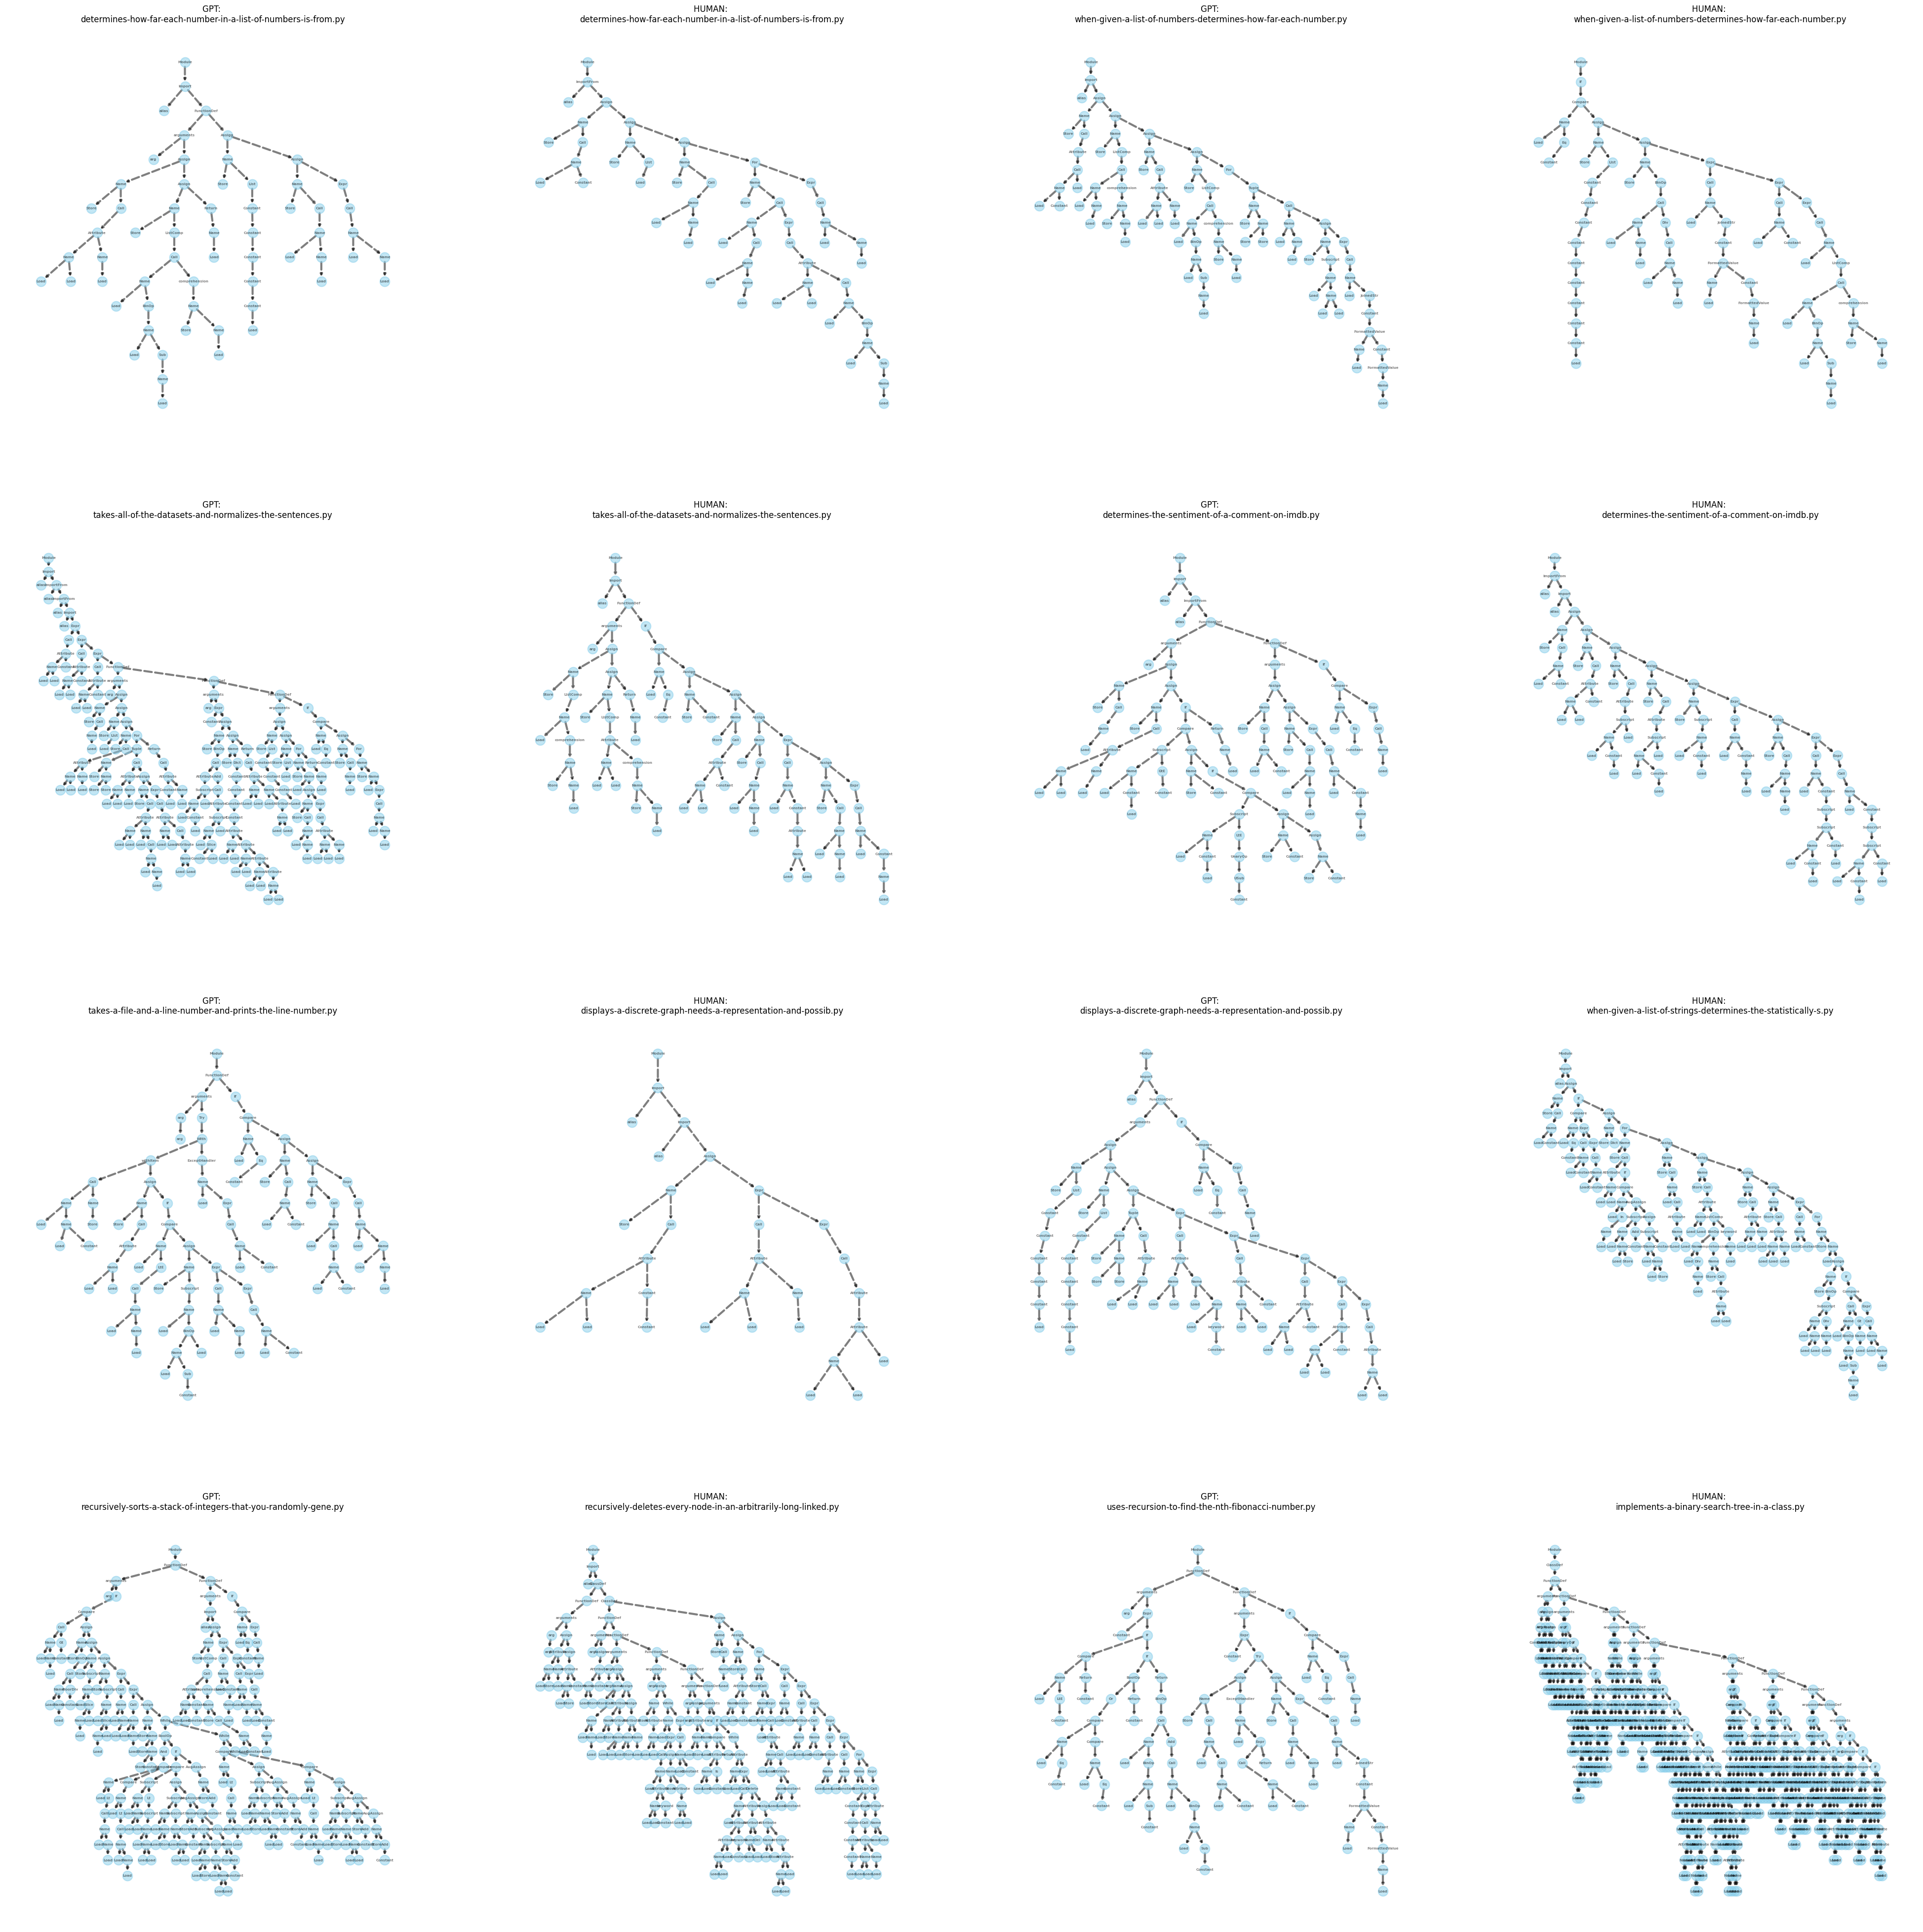

In [160]:
# Visualize some graphs from the ChatGPT dataset
from tqdm import tqdm
fig, ax = plt.subplots(4, 4, figsize=(50, 50))
for i in tqdm(range(0,4)):
    for j in range(0,4,2):
        plot_graph(ChatGPT_ast_graph_df.iloc[i*10+j]['Graph'], label="GPT: \n"+ChatGPT_ast_graph_df.iloc[i*10+j]['Filename'], ax =ax[i][j])
        plot_graph(humanCode_ast_graph_df.iloc[i*10+j]['Graph'], label="HUMAN: \n"+humanCode_ast_graph_df.iloc[i*10+j]['Filename'], ax =ax[i][j+1])